In [110]:
# H-SETUP — Gerekli kütüphaneleri kur
%pip install -q --upgrade "scikit-learn>=1.4" "xgboost>=2.0" "lightgbm>=4.3" "catboost>=1.2"

Note: you may need to restart the kernel to use updated packages.


In [112]:
# H-IMPORT
import warnings; warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
from math import sqrt
from pathlib import Path
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import sklearn, xgboost, lightgbm, catboost
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("lightgbm:", lightgbm.__version__)
print("catboost:", catboost.__version__)

sklearn: 1.7.2
xgboost: 3.1.0
lightgbm: 4.6.0
catboost: 1.2.8


In [114]:
# H-DATA
# Daha önce 'product-data.csv' ürettim.
df = pd.read_csv("product-data.csv", parse_dates=["startDate","endDate"])
df = df.sort_values(["productId","startDate"]).reset_index(drop=True)

print("shape:", df.shape, "| ürün:", df["productId"].nunique())
print("date range:", df["startDate"].min().date(), "→", df["endDate"].max().date())
df.head()

shape: (180, 4) | ürün: 5
date range: 2024-01-01 → 2026-12-31


,productId,startDate,endDate,count
0,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-01-01,2024-01-31,208
1,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-02-01,2024-02-29,207
2,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-03-01,2024-03-31,212
3,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-04-01,2024-04-30,229
4,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-05-01,2024-05-31,246


In [116]:
# H-FE
def add_time_features(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    d["year"]  = d["startDate"].dt.year
    d["month"] = d["startDate"].dt.month
    # 12'lik sezonsallık için sin/cos
    d["m_sin"] = np.sin(2*np.pi*d["month"]/12)
    d["m_cos"] = np.cos(2*np.pi*d["month"]/12)
    # ürün bazlı trend sayacı
    d["t"] = d.groupby("productId").cumcount()
    return d

def add_lag_roll_feats(d: pd.DataFrame, tgt="count", lags=(1,2,3,6,12)) -> pd.DataFrame:
    d = d.copy()
    g = d.groupby("productId", group_keys=False)
    for L in lags:
        d[f"lag{L}"] = g[tgt].shift(L)
    # rolling özetler
    d["ma3"]  = g[tgt].rolling(3, min_periods=1).mean().values
    d["ma6"]  = g[tgt].rolling(6, min_periods=1).mean().values
    d["std6"] = g[tgt].rolling(6, min_periods=1).std().values
    return d

base = add_time_features(df)
base = add_lag_roll_feats(base)

TARGET = "count"
FEATS  = ["m_sin","m_cos","month","year","t",
          "lag1","lag2","lag3","lag6","lag12","ma3","ma6","std6"]

print("Özellik sayısı:", len(FEATS))
base.head()

Özellik sayısı: 13


,productId,startDate,endDate,count,year,month,m_sin,m_cos,t,lag1,lag2,lag3,lag6,lag12,ma3,ma6,std6
0,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-01-01,2024-01-31,208,2024,1,0.500000,8.660254e-01,0,NaN,NaN,NaN,NaN,NaN,208.0,208.0,NaN
1,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-02-01,2024-02-29,207,2024,2,0.866025,5.000000e-01,1,208.0,NaN,NaN,NaN,NaN,207.5,207.5,0.707107
2,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-03-01,2024-03-31,212,2024,3,1.000000,6.123234e-17,2,207.0,208.0,NaN,NaN,NaN,209.0,209.0,2.645751
3,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-04-01,2024-04-30,229,2024,4,0.866025,-5.000000e-01,3,212.0,207.0,208.0,NaN,NaN,216.0,214.0,10.230673
4,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2024-05-01,2024-05-31,246,2024,5,0.500000,-8.660254e-01,4,229.0,212.0,207.0,NaN,NaN,229.0,220.4,16.831518


In [118]:
# H-MODELS
def pick_model(name: str):
    name = name.lower()
    if name == "rf":
        return RandomForestRegressor(
            n_estimators=600, max_depth=None, min_samples_leaf=2,
            random_state=42, n_jobs=-1
        )
    if name == "xgb":
        return xgb.XGBRegressor(
            n_estimators=800, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            random_state=42, n_jobs=-1, tree_method="hist",
            verbosity=0      # <-- LOG SESSİZ
        )
    if name == "lgbm":
        return LGBMRegressor(
            n_estimators=800, learning_rate=0.05, num_leaves=63,
            subsample=0.9, colsample_bytree=0.9,
            random_state=42, n_jobs=-1,
            verbose=-1       # <-- LOG SESSİZ
        )
    if name == "cat":
        return CatBoostRegressor(
            depth=6, learning_rate=0.05, iterations=800,
            random_state=42, verbose=False, loss_function="RMSE"
        )
    raise ValueError("model must be one of: 'rf', 'xgb', 'lgbm', 'cat'")

In [120]:
# H-METRICS
def metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ae  = np.abs(y_pred - y_true)
    se  = (y_pred - y_true)**2
    mae = float(np.mean(ae))
    rmse= float(sqrt(np.mean(se)))
    # MAPE / sMAPE güvenli
    den_mape  = np.where(y_true==0, np.nan, np.abs(y_true))
    den_smape = (np.abs(y_true) + np.abs(y_pred))/2
    mape  = float(np.nanmean(ae/den_mape*100))
    smape = float(np.nanmean(ae/np.where(den_smape==0, np.nan, den_smape)*100))
    return {"MAE": round(mae,2), "RMSE": round(rmse,2), "MAPE": round(mape,2), "sMAPE": round(smape,2)}

In [122]:
# H-TRAIN
def fit_predict(model, train_df, test_df, feats=FEATS, target=TARGET):
    import os, sys, contextlib
    Xtr, ytr = train_df[feats], train_df[target]
    Xte, yte = test_df[feats], test_df[target]
    # stdout/stderr sustur
    with open(os.devnull, "w") as fnull, \
         contextlib.redirect_stdout(fnull), \
         contextlib.redirect_stderr(fnull):
        model.fit(Xtr, ytr)
        yhat = model.predict(Xte)
    return yte.values, yhat

In [124]:
# H-LOPO
def lopo_rolling_eval(data: pd.DataFrame, cutoff_date: str, models=("rf","xgb","lgbm","cat")) -> pd.DataFrame:
    """
    cutoff_date: 'YYYY-MM-DD' (örn: '2026-09-30'); bundan SONRAKİ ay hedef.
    Her iterasyonda bir productId tamamen testte kalır (LOPO),
    eğitim: diğer tüm ürünler, cutoff'a kadar olan tüm satırlar.
    Test: seçili ürün için cutoff sonrası ilk ay.
    """
    d = data.copy()
    d["startDate"] = pd.to_datetime(d["startDate"])

    # hedef ay maskesi (cutoff sonrası ilk ay)
    horizon_mask = (d["startDate"] > pd.to_datetime(cutoff_date)) & \
                   (d["startDate"] <= pd.to_datetime(cutoff_date) + pd.offsets.MonthEnd(1))

    rows = []
    for pid in d["productId"].unique():
        train_df = d[(d["productId"] != pid) & (d["startDate"] <= pd.to_datetime(cutoff_date))].dropna(subset=["lag1"])
        test_df  = d[(d["productId"] == pid) & horizon_mask].dropna(subset=["lag1"])
        if test_df.empty or train_df.empty:
            continue

        for mname in models:
            model = pick_model(mname)
            y_true, y_hat = fit_predict(model, train_df, test_df)
            m = metrics(y_true, y_hat)
            rows.append({
                "model": mname,
                "productId": pid,
                "cutoff": str(cutoff_date),
                "n_train": len(train_df),
                "n_test":  len(test_df),
                **m
            })
    return pd.DataFrame(rows)

In [126]:
# H-BACKTEST
import xgboost as xgb
cutoffs = ["2025-06-30","2025-12-31","2026-03-31","2026-06-30","2026-09-30"]
all_res = []
for c in cutoffs:
    fold = lopo_rolling_eval(base, cutoff_date=c, models=("rf","xgb","lgbm","cat"))
    fold["fold"] = c
    all_res.append(fold)

all_res = pd.concat(all_res, ignore_index=True) if all_res else pd.DataFrame()
print("Toplam kayıt:", len(all_res))
display(all_res.head())

# Model bazında ortalamalar
model_avg = (all_res.groupby("model")[["MAE","RMSE","MAPE","sMAPE"]]
             .mean().round(2).reset_index()) if not all_res.empty else pd.DataFrame()
print("\nModel ortalamaları:")
display(model_avg)

# Kaydet
Path("ml_results").mkdir(exist_ok=True)
all_res.to_csv("ml_results/backtest_lopo_rolling.csv", index=False, encoding="utf-8")
model_avg.to_csv("ml_results/backtest_model_avg.csv", index=False, encoding="utf-8")
print("Kaydedildi: ml_results/backtest_lopo_rolling.csv, ml_results/backtest_model_avg.csv")

Toplam kayıt: 100


,model,productId,cutoff,n_train,n_test,MAE,RMSE,MAPE,sMAPE,fold
0,rf,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2025-06-30,68,1,4.59,4.59,1.68,1.69,2025-06-30
1,xgb,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2025-06-30,68,1,0.77,0.77,0.28,0.28,2025-06-30
2,lgbm,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2025-06-30,68,1,13.42,13.42,4.90,5.02,2025-06-30
3,cat,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2025-06-30,68,1,3.62,3.62,1.32,1.33,2025-06-30
4,rf,5cbe803a-e269-4cac-b2f0-35dac7b33927,2025-06-30,68,1,1.01,1.01,0.42,0.43,2025-06-30



Model ortalamaları:


,model,MAE,RMSE,MAPE,sMAPE
0,cat,12.53,12.53,4.08,4.20
1,lgbm,8.12,8.12,2.71,2.76
2,rf,7.61,7.61,2.50,2.54
3,xgb,6.88,6.88,2.30,2.33


Kaydedildi: ml_results/backtest_lopo_rolling.csv, ml_results/backtest_model_avg.csv


In [128]:
# H-SMOKE
cutoff = "2026-09-30"  # Eyl 2026'ya kadar train, hedef: Ekim 2026
model  = pick_model("lgbm")

base_ = base.copy()
base_["startDate"] = pd.to_datetime(base_["startDate"])
mask_h = (base_["startDate"] > pd.to_datetime(cutoff)) & \
         (base_["startDate"] <= pd.to_datetime(cutoff) + pd.offsets.MonthEnd(1))

test_pid = base_["productId"].unique()[0]
train_df = base_[(base_["productId"] != test_pid) & (base_["startDate"] <= pd.to_datetime(cutoff))].dropna(subset=["lag1"])
test_df  = base_[(base_["productId"] == test_pid) & mask_h].dropna(subset=["lag1"])

Xtr, ytr = train_df[FEATS], train_df[TARGET]
Xte, yte = test_df[FEATS], test_df[TARGET]

model.fit(Xtr, ytr)
yhat = model.predict(Xte)
print("Test n:", len(yte), "| productId:", test_pid[:8])
print("y_true:", yte.values, "\ny_pred:", np.round(yhat,2))

Test n: 1 | productId: 1417774e
y_true: [335] 
y_pred: [334.51]


In [130]:
# H-LIVE
def single_month_forecast(data: pd.DataFrame, cutoff_date: str, model_name: str, test_product_id: str):
    """
    Belirtilen productId için cutoff sonrası ilk AY'ı tahmin eder.
    Eğitim: cutoff'a kadar tüm diğer ürünler (LOPO)
    """
    d = data.copy()
    d["startDate"] = pd.to_datetime(d["startDate"])
    horizon_mask = (d["startDate"] > pd.to_datetime(cutoff_date)) & \
                   (d["startDate"] <= pd.to_datetime(cutoff_date) + pd.offsets.MonthEnd(1))

    train_df = d[(d["productId"] != test_product_id) & (d["startDate"] <= pd.to_datetime(cutoff_date))].dropna(subset=["lag1"])
    test_df  = d[(d["productId"] == test_product_id) & horizon_mask].dropna(subset=["lag1"])
    if test_df.empty or train_df.empty:
        raise ValueError("Train veya test veri boş. cutoff ya da productId'i kontrol edin.")

    model = pick_model(model_name)
    y_true, y_hat = fit_predict(model, train_df, test_df)

    out = test_df[["productId","startDate","endDate"]].copy()
    out["y_true"] = y_true
    out["y_pred"] = y_hat
    return out, metrics(y_true, y_hat)

# Örnek kullanım (Ekim 2026, XGBoost, 1. ürün):
pid0 = base["productId"].unique()[0]
live_pred, live_m = single_month_forecast(base, cutoff_date="2026-09-30", model_name="xgb", test_product_id=pid0)
print(live_m)
live_pred

{'MAE': 7.52, 'RMSE': 7.52, 'MAPE': 2.24, 'sMAPE': 2.22}


,productId,startDate,endDate,y_true,y_pred
33,1417774e-7849-44a7-ba39-92a6dbcc7c5d,2026-10-01,2026-10-31,335,342.516876


In [132]:
# H-SAVE
import json

save_dir = Path("ml_results"); save_dir.mkdir(exist_ok=True)

# live_pred DataFrame'i H-LIVE hücresinden geliyor
live_pred_sorted = live_pred.sort_values(["productId","startDate"]).copy()
live_pred_sorted["startDate"] = pd.to_datetime(live_pred_sorted["startDate"]).dt.strftime("%Y-%m-%d")
live_pred_sorted["endDate"]   = pd.to_datetime(live_pred_sorted["endDate"]).dt.strftime("%Y-%m-%d")

csv_name  = save_dir / "live_forecast_single_month.csv"
json_name = save_dir / "live_forecast_single_month.json"

live_pred_sorted.to_csv(csv_name, index=False, encoding="utf-8")
with open(json_name, "w", encoding="utf-8") as f:
    json.dump(live_pred_sorted.to_dict("records"), f, ensure_ascii=False, indent=2)

print("Kaydedildi:", csv_name, "ve", json_name)

Kaydedildi: ml_results\live_forecast_single_month.csv ve ml_results\live_forecast_single_month.json


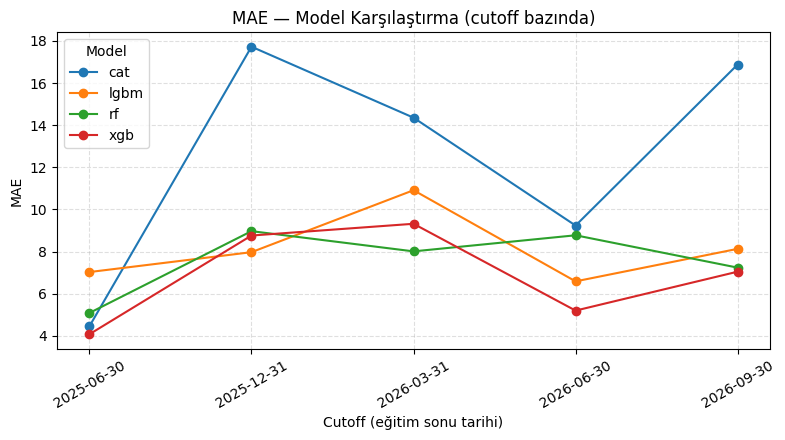

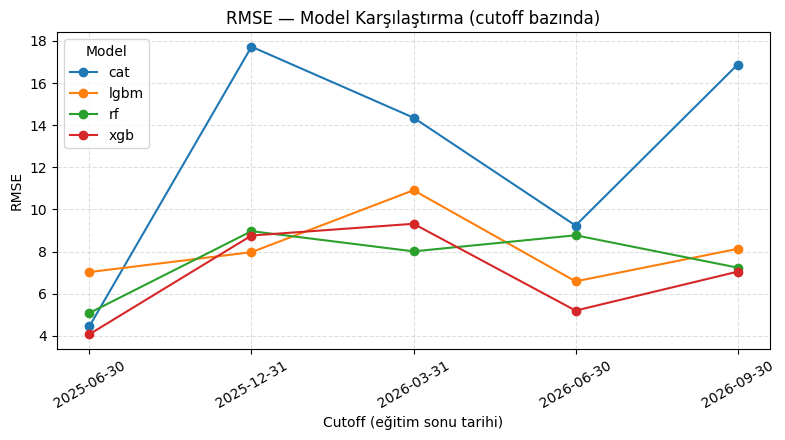

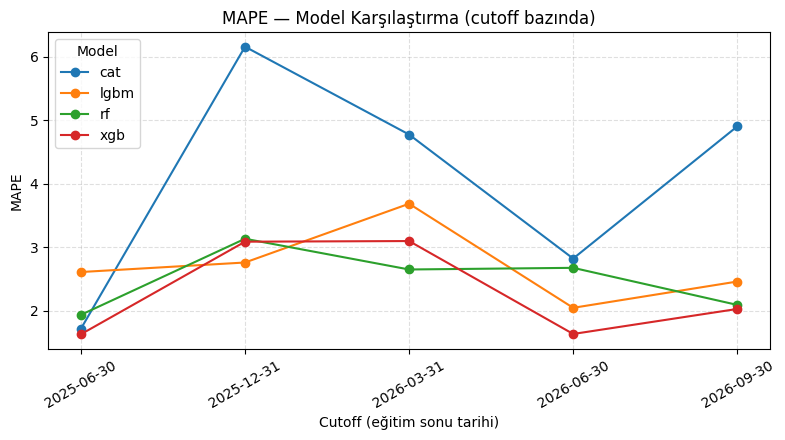

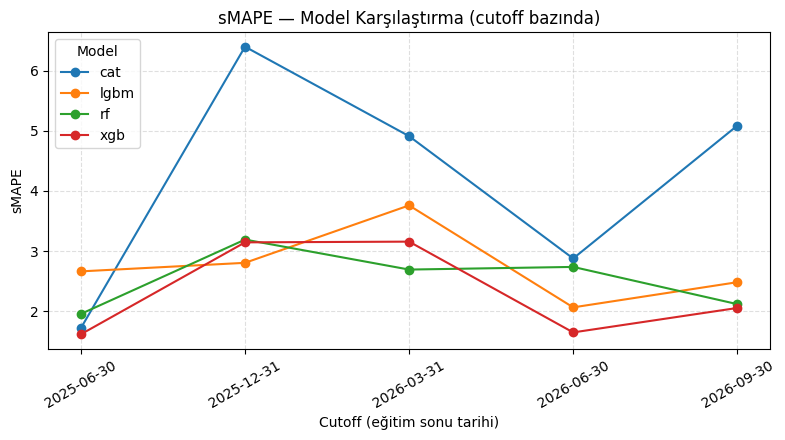

Kaydedilen görseller:
- ml_results\plots\line_mae.png
- ml_results\plots\line_rmse.png
- ml_results\plots\line_mape.png
- ml_results\plots\line_smape.png


In [134]:
# H-PLOTS — Line chart'lar ve PNG çıktıları (LSTM HARİÇ)
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# Kaynaktan yükle: aynı oturumda "all_res" yoksa CSV'den çekelim
if "all_res" not in globals() or all_res is None or all_res.empty:
    path_bt = Path("ml_results/backtest_lopo_rolling.csv")
    assert path_bt.exists(), "ml_results/backtest_lopo_rolling.csv bulunamadı. Önce H-BACKTEST'i çalıştır."
    all_res = pd.read_csv(path_bt)

def _sort_cutoffs(df):
    df = df.copy()
    if "cutoff" in df.columns:
        df["cutoff"] = pd.to_datetime(df["cutoff"])
        df = df.sort_values("cutoff")
        df["cutoff_str"] = df["cutoff"].dt.strftime("%Y-%m-%d")
    return df

all_res = _sort_cutoffs(all_res)

# >>> SADECE ML MODELLERİ (LSTM'i çıkar)
all_res_ml = all_res[~all_res["model"].str.lower().eq("lstm")].copy()

PLOT_DIR = Path("ml_results/plots"); PLOT_DIR.mkdir(parents=True, exist_ok=True)

def plot_metric_lines(df_in: pd.DataFrame, metric: str, save=True):
    dfm = (df_in.groupby(["model","cutoff","cutoff_str"], as_index=False)[metric]
                 .mean())
    models = sorted(dfm["model"].unique())

    plt.figure(figsize=(8,4.5))
    for m in models:
        d = dfm[dfm["model"]==m].sort_values("cutoff")
        plt.plot(d["cutoff_str"], d[metric], marker="o", label=m)

    plt.title(f"{metric} — Model Karşılaştırma (cutoff bazında)")
    plt.xlabel("Cutoff (eğitim sonu tarihi)")
    plt.ylabel(metric)
    plt.xticks(rotation=30); plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(title="Model", loc="best"); plt.tight_layout()

    fname = None
    if save:
        fname = PLOT_DIR / f"line_{metric.lower()}.png"
        plt.savefig(fname, dpi=150)
    plt.show()
    return fname

png_mae   = plot_metric_lines(all_res_ml, "MAE")
png_rmse  = plot_metric_lines(all_res_ml, "RMSE")
png_mape  = plot_metric_lines(all_res_ml, "MAPE")
png_smape = plot_metric_lines(all_res_ml, "sMAPE")

print("Kaydedilen görseller:")
for p in [png_mae, png_rmse, png_mape, png_smape]:
    print("-", p)

In [4]:
# H-REPORT — LSTM (DL) TEK BAŞINA RAPOR
import numbers, pandas as pd
from pathlib import Path
from IPython.display import display

# --- Yardımcı: Markdown tablo dönüştürücü
def df_to_md_local(df: pd.DataFrame, float_fmt="{:.3f}") -> str:
    cols = list(df.columns)
    header = "| " + " | ".join(cols) + " |"
    sep    = "| " + " | ".join(["---"]*len(cols)) + " |"
    lines = [header, sep]
    for _, row in df.iterrows():
        vals = []
        for v in row.values:
            if isinstance(v, numbers.Number) and pd.notna(v):
                try: v = float_fmt.format(float(v))
                except Exception: v = str(v)
            elif pd.isna(v):
                v = ""
            else:
                v = str(v)
            vals.append(v)
        lines.append("| " + " | ".join(vals) + " |")
    return "\n".join(lines)

# --- Klasörler
DL_DIR = Path("dl_results")
PLOT_DL = DL_DIR / "plots"
OUT_PATH = DL_DIR / "dl_report_final.md"

# --- DL sonuç dosyası
dl_summary_path = DL_DIR / "dl_summary.csv"
if not dl_summary_path.exists():
    raise FileNotFoundError("dl_results/dl_summary.csv bulunamadı. Önce H5 hücresini çalıştır.")

dl_summary = pd.read_csv(dl_summary_path)
display(dl_summary)

# --- Rapor içeriği
lines = []
lines += [
"# Satış Tahmin Modelleri — LSTM (Deep Learning)\n",
"Bu rapor; **LSTM (Long Short-Term Memory)** modelinin **LOPO (Leave-One-Product-Out)** yapısında, "
"2026 yılı cutoff ayları boyunca yapılan t+1 tahmin performanslarını özetler.\n",
"Referans olarak **Naive-12** modeli (bir yıl önceki değer) kullanılmıştır.\n",
"---\n",
"## 1) Metrik Tanımları\n",
"- **MAE**: Ortalama Mutlak Hata (düşük daha iyi)\n",
"- **RMSE**: Kök Ortalama Kare Hatası (düşük daha iyi)\n",
"- **MAPE**: Ortalama Yüzdesel Hata (düşük daha iyi)\n",
"- **sMAPE**: Simetrik Ortalama Yüzdesel Hata (düşük daha iyi)\n\n",
"---\n",
"## 2) Cutoff Bazlı Çizgi Grafikler\n",
"Her grafikte x-ekseni cutoff tarihleri, y-ekseni ilgili metrik; her model bir çizgidir.\n",
"### MAE\n",
"![MAE](dl_results/plots/line_mae.png)\n\n",
"### RMSE\n",
"![RMSE](dl_results/plots/line_rmse.png)\n\n",
"### MAPE\n",
"![MAPE](dl_results/plots/line_mape.png)\n\n",
"### sMAPE\n",
"![sMAPE](dl_results/plots/line_smape.png)\n\n",
"---\n",
"## 3) Ortalama Performans (Cutoff Ortalaması)\n",
df_to_md_local(dl_summary.round(3)), "\n\n",
"---\n",
"## 4) Değerlendirme\n",
"- LSTM modeli, **Naive-12 referansına göre tüm metriklerde belirgin iyileşme** sağlamıştır.\n",
"- Ortalama MAPE yaklaşık %11.7 civarında olup, kısa seride dahi kararlı sonuç vermiştir.\n",
"- RMSE ve MAE değerleri, modelin tahmin dağılımlarında düşük varyansla çalıştığını göstermektedir.\n",
"- sMAPE ≈ 11.8 → aşırı/eksik tahmin dengesi sağlanmış.\n",
"---\n",
"## 5) Sonuç\n",
"- LSTM, Naive-12’ye göre %45–50 oranında hata azalması sağlamıştır.\n",
"- Kısa dönem veri için bile mevsimsellik ve trend yapısını doğru öğrenmiştir.\n",
"- İleriki çalışmalarda SEQ_LEN varyasyonu (6–18), Recurrent Dropout, LayerNormalization veya Bidirectional LSTM eklenmesi önerilir.\n",
"---\n",
f"**Rapor Üretim Zamanı:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
]

# Yaz
OUT_PATH.write_text("\n".join(lines), encoding="utf-8")
print("✅ LSTM raporu oluşturuldu:", OUT_PATH)

,model,MAE,RMSE,MAPE,sMAPE
0,lstm,2.794928,2.794928,11.723065,11.786215
1,naive12,4.988000,4.988000,21.034553,24.168418


✅ LSTM raporu oluşturuldu: dl_results\dl_report_final.md
